# Dimensionality Reduction

This notebook evaluates methods for dimensionality reduction using the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump.

## Table of Contents
* [Data Import](#data_import)
* [Data Preparation](#data_preparation)
* [Dimensionality Reduction Methods](#methods)

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import math
import time

warnings.filterwarnings('ignore')
plt.style.use('plotstyle.mplstyle')

<a id='data_import'/>

## Data Import

In [2]:
from academia_tag_recommender.experiments.data import ExperimentalData

ed = ExperimentalData.load()
X_train, X_test, y_train, y_test = ed.get_train_test_set()

<a id='data_preparation'/>

## Data Preparation

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from academia_tag_recommender.tokenizer import BasicTokenizer
from academia_tag_recommender.preprocessor import BasicPreprocessor
from academia_tag_recommender.stopwords import stopwordlist

vectorizer = TfidfVectorizer(min_df=2, tokenizer=BasicTokenizer(), preprocessor=BasicPreprocessor(), stop_words=stopwordlist, ngram_range=(1, 1))
X = vectorizer.fit_transform(np.array([*X_train, *X_test]))
print('X data with shape {}'.format(X.shape))

y = np.array([*y_train, *y_test])
print('Y data with shape {}'.format(y.shape))

X data with shape (33082, 21958)
Y data with shape (33082, 190)


<a id='methods'/>

## Dimensionality Reduction Methods

- [CHI](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html), [Explanation](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)
- [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
- [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD), [Explanation](https://scikit-learn.org/stable/modules/decomposition.html#truncated-singular-value-decomposition-and-latent-semantic-analysis), [Example](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)

In [4]:
def test_with_k(method, K):
    begin = time.time()
    method(K)
    end = time.time()
    time_passed = end - begin
    print('Time with k = {:>5} : {:.3f}s'.format(K, time_passed))

**CHI**

[Chi-squared](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) is a statistic measure for dependence between variables. Based on the chi2 statistic the *k* best [univariate features](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) are selected using [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest).

In [5]:
from sklearn.feature_selection import SelectKBest, chi2

def chi(K):
    selector = SelectKBest(chi2, k=K)
    X_new = selector.fit_transform(X, y)
    
test_with_k(chi, 2)
test_with_k(chi, 100)
test_with_k(chi, 1000)

Time with k =     2 : 2.124s
Time with k =   100 : 1.179s
Time with k =  1000 : 1.432s


Results for `K = 2` can be visualized to show the transformed values in the two-dimensional feature space.

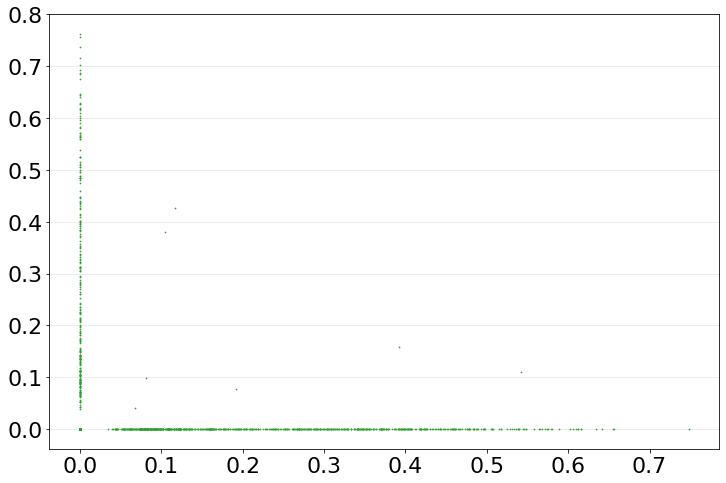

In [6]:
K = 2

selector = SelectKBest(chi2, k=K)
X_new = selector.fit_transform(X, y)
X_new = X_new.toarray()

plt.figure()
plt.scatter(X_new[:,0], X_new[:,1], s=0.5, color='tab:green')
plt.show()

**NMF**

[Non-negative matrix factorization](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) is a decomposition method used for dimensionality reduction. 
> The logic for Dimensionality Reduction is to take our m×n data and to decompose it into two matrices of m×features and features×n respectively. The features will be the reduced dimensions.
>[Pipis (2020)](https://predictivehacks.com/non-negative-matrix-factorization-for-dimensionality-reduction/)

In this case our data has dimensions *N×M* and the decomposed matrices are of shape *W=N×K* and *H=K×M*.

Based on Kobayashi et.al. (2019) `n_components` should be calculated by `(N+M)K < NM` where `M`: number of original features, `N`: size of corpus and `K`: number of dimensions to retain.

In [7]:
N = X.shape[0]
M = X.shape[1]
K = N*M / (N+M)
print('K should not be greater than', K)

K should not be greater than 13197.938880813954


In [ ]:
from sklearn.decomposition import NMF

def nmf(K):
    model = NMF(n_components=int(K), init='random', random_state=0)
    W = model.fit_transform(X)
    
test_with_k(nmf, 2)
test_with_k(nmf, 100)
test_with_k(nmf, 1000)
test_with_k(nmf, N*M / (N+M))

Time with k =     2 : 1.208s
Time with k =   100 : 163.147s
Time with k =  1000 : 16181.290s


Results for `K = 2` can be visualized to show the transformed values in the two-dimensional feature space.

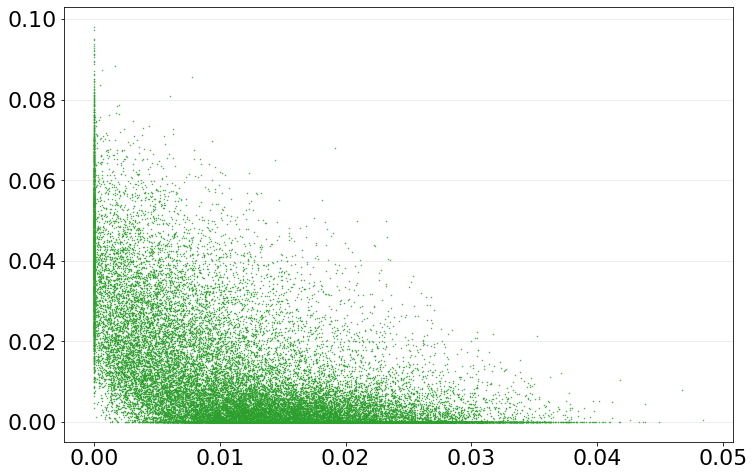

In [6]:
K = 2

model = NMF(n_components=int(K), init='random', random_state=0)
W = model.fit_transform(X)

plt.figure()
plt.scatter(W[:,0], W[:,1], s=0.2, color='tab:green')
plt.show()

**Latent Semantic Analysis (LSA)**

[Dimensionality reduction using truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) is a decomposition method used for linear dimensionality reduction. It is generally known as LSA.

> SVD deals with decomposing a matrix into a product of 3 matrices as shown: A=USV^T
> [Mahendru (2019)](https://www.analyticsvidhya.com/blog/2019/08/5-applications-singular-value-decomposition-svd-data-science/)


Based on Kobayashi et.al. (2019) `n_components` should be calculated by `K = N * (1 / (1+ (log(N) / 10)))` `N`: size of corpus and `K`: number of dimensions to retain.

Based on sklearn a recommended value for `n_components` is 100.

In [7]:
N = X.shape[0]
K = N * (1 / (1+ (math.log10(N))))
print('K should be approximately', K)

K should be approximately 5993.559207740943


In [8]:
from sklearn.decomposition import TruncatedSVD

def lsa(K):
    lsa = TruncatedSVD(n_components=int(K), random_state=0)
    X_new = lsa.fit_transform(X)
    
test_with_k(lsa, 2)
test_with_k(lsa, 100)
test_with_k(lsa, 1000)
test_with_k(lsa, N * (1 / (1+ (math.log10(N)))))

Time with k =     2 : 0.551s
Time with k =   100 : 4.075s
Time with k =  1000 : 49.636s
Time with k = 5993.559207740943 : 893.605s


Results for `K = 2` can be visualized to show the transformed values in the two-dimensional feature space.

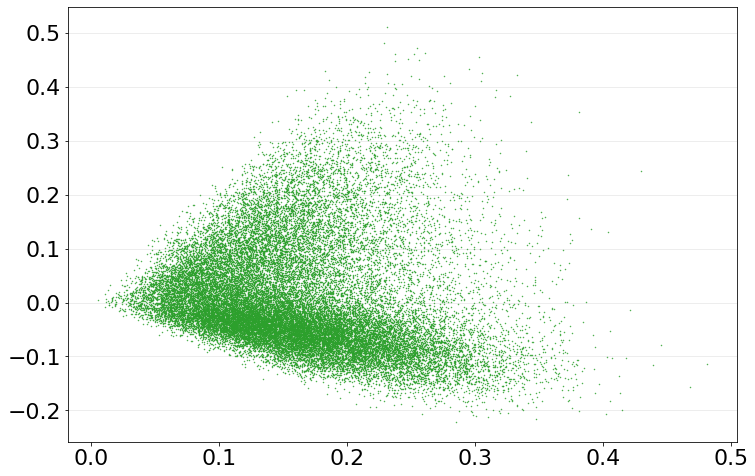

In [9]:
K = 2

lsa = TruncatedSVD(n_components=int(K), random_state=42)
X_new = lsa.fit_transform(X)

plt.figure()
plt.scatter(X_new[:,0], X_new[:,1], s=0.2, color='tab:green')
plt.show()